In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import face3d
import vxl
import pix2face
from PIL import Image

In [2]:
%matplotlib inline

### Estimate PNCC and Offsets using pix2face network

In [3]:
pix2face_data_dir = '/pix2face/pix2face_net/data'

cpu_only = int(os.environ.get("CPU_ONLY")) != 0
cuda_device = None if cpu_only else 0
if cpu_only:
    print("Running on CPU")
else:
    print("Running on cuda device %s" % cuda_device)

Running on cuda device 0


In [4]:
model = pix2face.test.load_pretrained_model(cuda_device=cuda_device)

loading /pix2face/pix2face_net/data/models/pix2face_unet_v10_pytorch0.4_cpu.pt ...
...done.


In [5]:
img_fname = os.path.join(pix2face_data_dir, 'CASIA_0000107_004.jpg')
img = np.array(Image.open(img_fname))
outputs = pix2face.test.test(model, [img,])
pncc = outputs[0][0]
offsets = outputs[0][1]

In [6]:
pncc_rgb = pncc / 300.0 + 0.5
offsets_rgb = offsets / 60.0 + 0.5

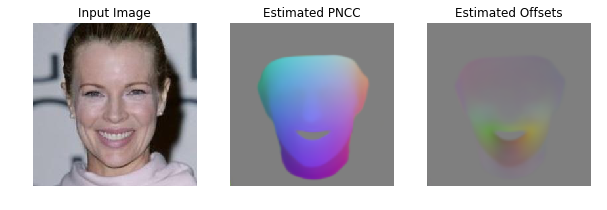

In [7]:
fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(img)
ax[0].set_title('Input Image')
ax[1].imshow(pncc_rgb)
ax[1].set_title('Estimated PNCC')
ax[2].imshow(offsets_rgb)
ax[2].set_title('Estimated Offsets')
for a in ax:
    a.axis('off')

In [8]:
pvr_data_dir = '/pix2face/face3d/data_3DMM'
debug_dir = ''
debug_mode = False

In [9]:
# load needed data files
head_mesh = face3d.head_mesh(pvr_data_dir)
subject_components = vxl.vnl.matrix(np.load(os.path.join(pvr_data_dir, 'pca_components_subject.npy')))
expression_components = vxl.vnl.matrix(np.load(os.path.join(pvr_data_dir, 'pca_components_expression.npy')))
subject_ranges = vxl.vnl.matrix(np.load(os.path.join(pvr_data_dir,'pca_coeff_ranges_subject.npy')))
expression_ranges = vxl.vnl.matrix(np.load(os.path.join(pvr_data_dir,'pca_coeff_ranges_expression.npy')))
renderer = face3d.mesh_renderer()

In [10]:
subject_components.shape

(63, 10344)

In [11]:
# create coefficient estimator
coeff_estimator = face3d.media_coefficient_from_PNCC_and_offset_estimator(head_mesh, subject_components, expression_components, subject_ranges, expression_ranges, debug_mode, debug_dir)

### Estimate Coefficients from PNCC and Offsets

In [12]:
# estimate coefficients
img_ids = ['img0',]
coeffs, result = coeff_estimator.estimate_coefficients_perspective(img_ids, [pncc,], [offsets,])
if not result.success:
    raise Exception('Coefficient Estimation Failed')

In [13]:
# render synthetic image with estimated coefficients
green_tex = np.zeros((64,64,3), np.uint8)
green_tex[:,:,1] = 255

head_mesh.apply_coefficients(subject_components, expression_components, coeffs.subject_coeffs(), coeffs.expression_coeffs(0))
meshes = head_mesh.meshes()
for mesh in meshes:
    mesh.set_texture(green_tex)

render = renderer.render(meshes, coeffs.camera(0))

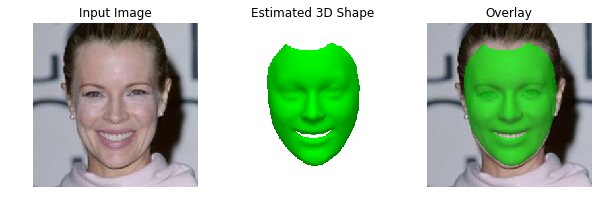

In [14]:
fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(img)
ax[0].set_title('Input Image')
ax[1].imshow(render)
ax[1].set_title('Estimated 3D Shape')
mask = render[:,:,3] > 0
blended = np.array(img)
img_weight = 0.3
blended[mask] = blended[mask]*img_weight + render[mask,0:3]*(1.0 - img_weight)
ax[2].imshow(blended)
ax[2].set_title('Overlay')
for a in ax:
    a.axis('off')

### Render 3D-Jittered Images

In [15]:
jitterer = face3d.media_jitterer_perspective([img,], coeffs, head_mesh, subject_components, expression_components, renderer, "")


In [16]:
num_subject_components = len(coeffs.subject_coeffs())
num_expression_components = len(coeffs.expression_coeffs(0))
pose_jitterer_uniform = face3d.pose_jitterer_profile(pvr_data_dir, num_subject_components, num_expression_components, "/tmp", 20, 60, cuda_device)

In [17]:
new_expression_coeffs = np.zeros_like(coeffs.expression_coeffs(0))
# manually alter expression
new_expression_coeffs[0] = 0.2 #anger
new_expression_coeffs[1] = -0.1 #disgust
new_expression_coeffs[2] = 0.5 # fear
new_expression_coeffs[3] = 1 # happiness
new_expression_coeffs[4] = 0.3 # sadness
new_expression_coeffs[5] = 0.1 #surprise
render_neutral = jitterer.render(coeffs.camera(0), coeffs.subject_coeffs(), new_expression_coeffs, subject_components, expression_components)


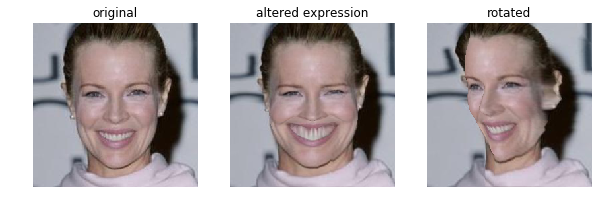

In [18]:
render_rot = pose_jitterer_uniform.get_random_jitter([img,], coeffs, 1)
fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(img)
ax[0].set_title('original')
ax[1].imshow(render_neutral[:,:,0:3])
ax[1].set_title('altered expression')
ax[2].imshow(render_rot[:,:,0:3])
ax[2].set_title('rotated')
for a in ax:
    a.axis('off')